<a href="https://colab.research.google.com/github/microprediction/firstdown/blob/main/more_comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/microprediction/nflMarkov/master/inputData/pbp_nfldb_2009_2013.csv')
pd.set_option('mode.chained_assignment',None)

## Do you want 2nd and 1-yard or 1st and 10-yards? 
Thanks Ben Dilday for compiling the down data. 

This notebook examines 2nd down and close positions, and considers the question of whether 2nd down and 1 is superior to 1st down and 10 (plus one yard)

### Step 1: We add the final field position achieved in the drive and a few other things... 

In [ ]:
drive_start = 0
drive_starts = list()

drive_index = 0
drive_indexes = list()
down_index = 0
down_indexes = list()
running_first_yfogs = list()    # Best field position of drive at 1st down
running_yfogs = list() # just a check
running_yfog = 0 
best_first_yfog = 0 
prev_team = None 
is_first_play_of_drive = True 
is_firsts = list()

for yfog, dwn, posteam in zip(df['yfog'].values,df['dwn'].values, df['posteam'].values):

    is_first_play_of_drive = (prev_team != posteam )
    is_firsts.append(dwn==1)
    if is_first_play_of_drive:
        drive_start = yfog 
        drive_index += 1 
         
    # Update best field position for the drive 
    running_yfog = yfog 
    if dwn==1:
        running_first_yfog = yfog

    # Update    
    running_first_yfogs.append(running_first_yfog)
    running_yfogs.append(running_yfog)
    drive_indexes.append(drive_index)
    drive_starts.append(drive_start)

    if (posteam!=prev_team):
       down_index += 1 
       down_indexes.append(down_index)
    else:
       down_indexes.append(down_index)
       if dwn==1:
          down_index+=1 

    prev_team = posteam 
     
df['is_first'] = is_firsts
df['running_yfog'] = running_yfogs
df['running_first_yfog'] = running_first_yfogs
df['drive_index'] = drive_indexes
df['drive_start'] = drive_starts
df['down_index'] = down_indexes
   
df['eventual_yfog'] = df[['drive_index','running_yfog']].groupby('drive_index').transform(max)
df['eventual_down_yfog_raw'] = df[['down_index','running_yfog']].groupby('down_index').transform(max)
df['eventual_down_yfog'] = [ d1 if dwn>1 else d2 for d1, d2, dwn in zip (df['eventual_down_yfog_raw'],df['eventual_down_yfog_raw'].shift(-1),df['dwn']) ]
del df['eventual_down_yfog_raw']

df['eventual_first_yfog'] = df[['drive_index','running_first_yfog']].groupby('drive_index').transform(max)
df['eventual_drive'] = df['eventual_yfog'] - df['drive_start']
df['eventual_gain'] = df['eventual_yfog'] - df['yfog']
df['eventual_down_gain'] = df['eventual_down_yfog'] - df['yfog']
df['will_get_first_down'] = df['eventual_down_gain']>=df['ytg']
assert all(df['running_yfog']==df['yfog'])




In [ ]:
df[70:80]

,game_id,playername,dwn,ytg,yfog,type,posteam,yds,seas,away_team,home_team,is_first,running_yfog,running_first_yfog,drive_index,drive_start,down_index,eventual_yfog,eventual_down_yfog,eventual_first_yfog,eventual_drive,eventual_gain,eventual_down_gain,will_get_first_down
70,2009091000,WillieParker,2,2,54,RUSH,PIT,1,2009,TEN,PIT,False,54,46,15,46,33,55,55.0,46,9,1,1.0,False
71,2009091000,WillieParker,3,1,55,RUSH,PIT,0,2009,TEN,PIT,False,55,46,15,46,33,55,55.0,46,9,0,0.0,False
72,2009091000,ChrisJohnson,1,10,5,RUSH,TEN,1,2009,TEN,PIT,True,5,5,16,5,34,6,6.0,5,1,1,1.0,False
73,2009091000,ChrisJohnson,2,9,6,RUSH,TEN,0,2009,TEN,PIT,False,6,5,16,5,34,6,6.0,5,1,0,0.0,False
74,2009091000,ChrisJohnson,3,9,6,RUSH,TEN,-2,2009,TEN,PIT,False,6,5,16,5,34,6,6.0,5,1,0,0.0,False
75,2009091000,BenRoethlisberger,1,10,46,PASS,PIT,0,2009,TEN,PIT,True,46,46,17,46,35,60,57.0,57,14,14,11.0,True
76,2009091000,WillieParker,2,10,46,RUSH,PIT,4,2009,TEN,PIT,False,46,46,17,46,35,60,57.0,57,14,14,11.0,True
77,2009091000,BenRoethlisberger,3,6,50,PASS,PIT,7,2009,TEN,PIT,False,50,46,17,46,35,60,57.0,57,14,10,7.0,True
78,2009091000,BenRoethlisberger,1,10,57,RUSH,PIT,3,2009,TEN,PIT,True,57,57,17,46,35,60,60.0,57,14,3,3.0,False
79,2009091000,WillieParker,2,7,60,RUSH,PIT,-3,2009,TEN,PIT,False,60,57,17,46,36,60,60.0,57,14,0,0.0,False


In [ ]:
df_1st_10 = df[(df['ytg']==10) & (df['dwn']==1) & (df['yfog']<=51)]
df_1st_10[['eventual_down_gain','eventual_gain']].groupby('eventual_down_gain').count().reset_index().rename(columns={'eventual_gain':'count'}).sort_values('count',ascending=False)[1:15]

,eventual_down_gain,count
41,0.0,3311
53,12.0,2678
54,13.0,2240
55,14.0,1935
51,10.0,1769
56,15.0,1701
57,16.0,1478
58,17.0,1276
43,2.0,1112
46,5.0,1109


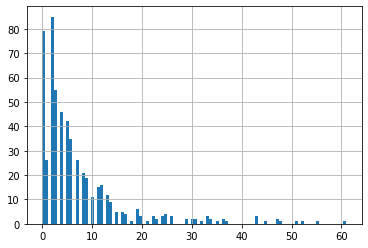

In [ ]:
df_2nd_1 = df[(df['ytg']==1) & (df['dwn']==2) & (df['yfog']<=30)]
df_2nd_1['eventual_down_gain'].hist(bins=100)

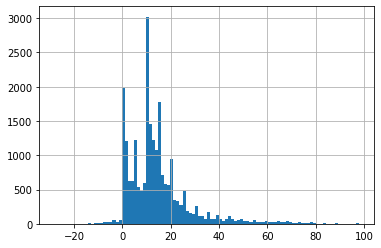

In [ ]:
df_1st_10 = df[(df['ytg']==10) & (df['dwn']==1) & (df['yfog']<=31)]
df_1st_10['eventual_down_gain'].hist(bins=100)

Inside one's own territory, are you more likely to advance a long way from 1st and 10 or 2nd and 1? 

In [ ]:
df_2nd_1 = df[(df['ytg']==1) & (df['dwn']==2) & (df['yfog']<=30)]
df_2nd_1['drive_success'] = (df_2nd_1['eventual_yfog']-df_2nd_1['yfog'])>21
df_2nd_1['drive_success'].mean()

0.6099290780141844

In [ ]:
df_1st_10 = df[(df['ytg']==10) & (df['dwn']==1) & (df['yfog']<=31)]
df_1st_10['drive_success'] = (df_1st_10['eventual_yfog']-df_1st_10['drive_start'])>20
df_1st_10['drive_success'].mean()

0.5746527777777778

We see that a team has a 60% chance of achieving a 1st down at least 21 yards further down the field from 2nd and 1, whereas the equivalent gain from 1st and 10 occurs only 57% of the time. 

Now what if we specialize to 2nd and 1 on the 39 yard line?

In [ ]:
df_2nd_1_29 = df[(df['ytg']==1) & (df['dwn']==2) & (df['yfog']==39)]
df_2nd_1_29['drive_success'] = (df_2nd_1_29['eventual_yfog']-df_2nd_1_29['drive_start'])>31
(df_2nd_1_29['drive_success'].mean(), df_2nd_1_29['drive_success'].count())


(0.6046511627906976, 43)

In [ ]:
df_1st_10_30 = df[(df['ytg']==10) & (df['dwn']==1) & (df['yfog']==40)]
df_1st_10_30['drive_success'] = (df_1st_10_30['eventual_yfog']-df_1st_10_30['drive_start'])>30
(df_1st_10_30['drive_success'].mean(), df_1st_10_30['drive_success'].count())

(0.5722070844686649, 1101)

Another way to come at this is looking at average yards ... 

In [ ]:
df[(df['dwn']==1) & (df['ytg']==10) & (df['yfog']==40)]['eventual_gain'].mean()

25.929155313351497

In [ ]:
df[(df['dwn']==2) & (df['ytg']==1) & (df['yfog']==39)]['eventual_gain'].mean()

28.023255813953487

But on average, across field positions, it is pretty close...

In [ ]:
df[(df['dwn']==1) & (df['ytg']==10) & (df['yfog']>20) & (df['yfog']<70)]['eventual_gain'].mean()

24.854384133611692

In [ ]:
df[(df['dwn']==2) & (df['ytg']==1) & (df['yfog']>20) & (df['yfog']<70)]['eventual_gain'].mean()-1

24.93287827076223

We can look at average yards on the drive

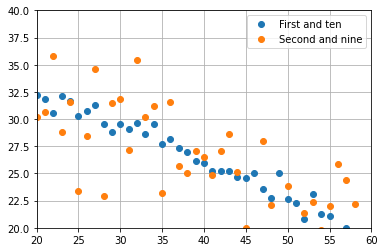

In [ ]:
df_ytg_10 = df[(df['dwn']==1) & (df['ytg']==10)]
summary_10 = df_ytg_10[['yfog','eventual_gain']].groupby('yfog').mean().reset_index()
df_ytg_9 = df[(df['dwn']==2) & (df['ytg']==1)]
df_ytg_9['eventual_gain_less'] = df_ytg_9['eventual_gain'] - 1 
summary_9 = df_ytg_9[['yfog','eventual_gain_less']].groupby('yfog').mean().reset_index()
import matplotlib.pyplot as plt

plt.plot(summary_10['yfog'],summary_10['eventual_gain'], summary_9['yfog'],summary_9['eventual_gain_less'],marker='o',linestyle='None')
plt.grid()
plt.xlim(20,60)
plt.ylim(20,40)
plt.legend(['First and ten','Second and nine'])

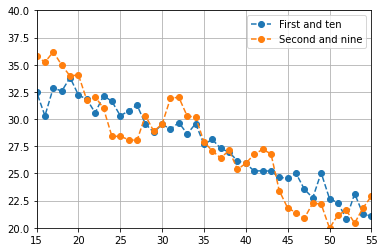

In [ ]:
from scipy.signal import savgol_filter
summary_9['eventual_gain_less_smoothed'] = savgol_filter(summary_9['eventual_gain_less'].values,7,3)
plt.plot(summary_10['yfog'],summary_10['eventual_gain'], summary_9['yfog'],summary_9['eventual_gain_less_smoothed'],marker='o',linestyle='--')
plt.grid()
plt.xlim(15,55)
plt.ylim(20,40)
plt.legend(['First and ten','Second and nine'])


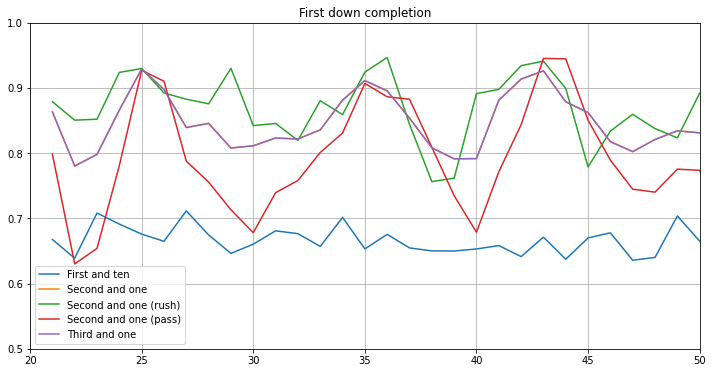

In [ ]:
df_ytg_10 = df[(df['dwn']==1) & (df['ytg']==10)& (df['yfog']<70) & (df['yfog']>20)]
summary_10 = df_ytg_10[['yfog','will_get_first_down']].groupby('yfog').mean().reset_index()
df_ytg_92 = df[(df['dwn']==2) & (df['ytg']==1)& (df['yfog']<70) & (df['yfog']>20)]
summary_92 = df_ytg_92[['yfog','will_get_first_down']].groupby('yfog').mean().reset_index()
summary_92['will_get_first_down_smoothed'] = savgol_filter(summary_92['will_get_first_down'],7,3)
df_ytg_93 = df[(df['dwn']==3) & (df['ytg']==1)& (df['yfog']<70) & (df['yfog']>20)]
summary_93 = df_ytg_93[['yfog','will_get_first_down']].groupby('yfog').mean().reset_index()
summary_93['will_get_first_down_smoothed'] = savgol_filter(summary_93['will_get_first_down'],7,3)

# Run versus pass
df_ytg_92_r = df[(df['dwn']==2) & (df['ytg']==1) & (df['type']=='RUSH') & (df['yfog']<70) & (df['yfog']>20)]
df_ytg_92_p = df[(df['dwn']==2) & (df['ytg']==1) & (df['type']=='PASS') & (df['yfog']<70) & (df['yfog']>20)]
summary_92_r = df_ytg_92_r[['yfog','will_get_first_down']].groupby('yfog').mean().reset_index()
summary_92_r['will_get_first_down_smoothed'] = savgol_filter(summary_92_r['will_get_first_down'],5,2)
summary_92_p = df_ytg_92_p[['yfog','will_get_first_down']].groupby('yfog').mean().reset_index()
summary_92_p['will_get_first_down_smoothed'] = savgol_filter(summary_92_p['will_get_first_down'],7,3)


import matplotlib.pyplot as plt
plt.plot(summary_10['yfog'],summary_10['will_get_first_down'], summary_92['yfog'],summary_92['will_get_first_down_smoothed'],
         summary_92_r['yfog'],summary_92_r['will_get_first_down_smoothed'],
         summary_92_p['yfog'],summary_92_p['will_get_first_down_smoothed'],
          summary_92['yfog'],summary_92['will_get_first_down_smoothed'])
plt.grid()
plt.xlim(20,50)
plt.ylim(0.5,1)
plt.legend(['First and ten','Second and one','Second and one (rush)','Second and one (pass)','Third and one'])
plt.title('First down completion')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc_params

Yards gained rushing on 2nd and 1

Yards gained rushing on 2nd and 1, conditional on success

Text(0, 0.5, 'Yards gained')

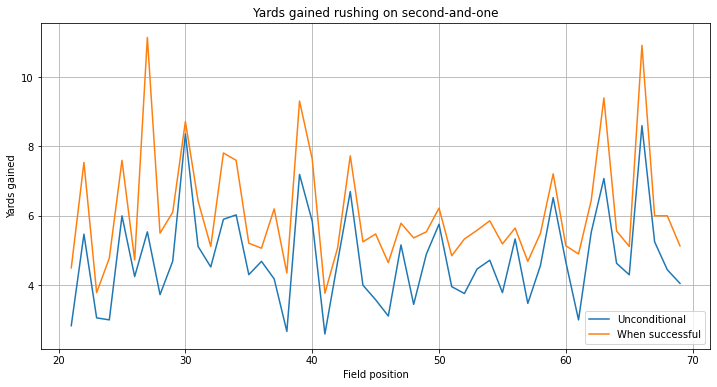

In [ ]:
rush21 = df_ytg_92_r[['yds','yfog']].groupby('yfog').mean().reset_index()
df_ytg_92_r_suc = df_ytg_92_r[df_ytg_92_r['yds']>=1]
rush21_suc = df_ytg_92_r_suc[['yds','yfog']].groupby('yfog').mean().reset_index()
plt.plot(rush21['yfog'].values,rush21['yds'].values,rush21_suc['yfog'].values,rush21_suc['yds'].values)
plt.legend(['Unconditional','When successful'])
plt.grid()
plt.title('Yards gained rushing on second-and-one')
plt.xlabel('Field position')
plt.ylabel('Yards gained')

Average yards rushing on 3rd and 1 for "regular" field position (20,70)

In [ ]:
df_ytg_93_r = df[(df['dwn']==3) & (df['ytg']==1) & (df['type']=='RUSH') & (df['yfog']<70) & (df['yfog']>20)]
df_ytg_93_p = df[(df['dwn']==3) & (df['ytg']==1) & (df['type']=='PASS') & (df['yfog']<70) & (df['yfog']>20)]
rush3 = df_ytg_93_r[df_ytg_93_r['yds']>=1]
rush3['yds'].mean()

4.671961874503574

## Bad outcomes - rushing
Let's assume we stop shy of the first down then rush twice

0.1896551724137931


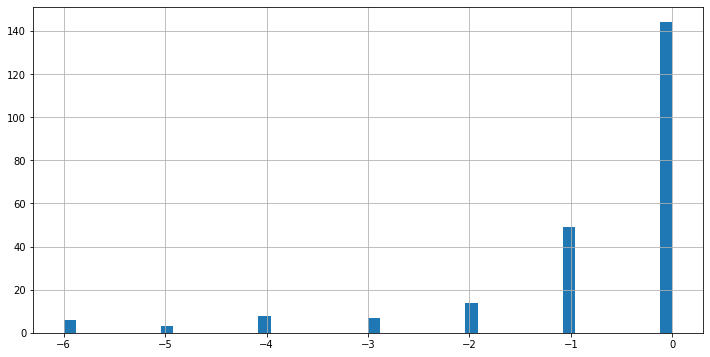

In [ ]:
df_ytg_92_r_bad = df_ytg_92_r[df_ytg_92_r['yds']<1]
df_ytg_92_r_bad['yds'].hist(bins=50)
n = len(df_ytg_92_r)
n_bad = len(df_ytg_92_r_bad)
print(n_bad/n)

Yards gained rushing on 3rd and 1, conditional on success

## Bad outcomes - passing 

(231, 540)


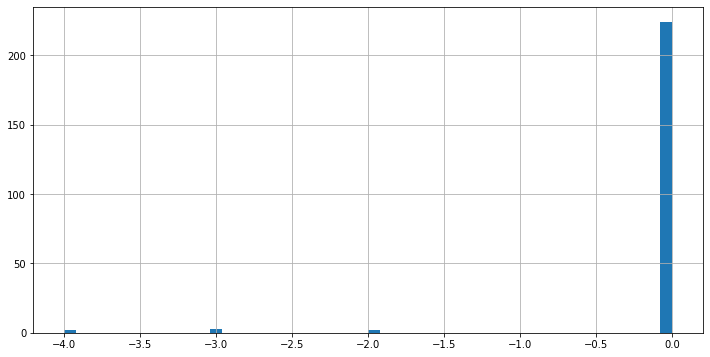

In [ ]:
df_ytg_92_p_bad = df_ytg_92_p[df_ytg_92_p['yds']<1]
df_ytg_92_p_bad['yds'].hist(bins=50)
n = len(df_ytg_92_p)
n_bad = len(df_ytg_92_p_bad)
print((n_bad,n))
n_really_bad = len(df_ytg_92_p[df_ytg_92_p['yds']<0])

In [ ]:
# Useful yards